# Landsat-8 Bands Visualization
------------

## Introduction

### Overview

Inspired by https://gisgeography.com/landsat-8-bands-combinations/, I decided to brush off my Landsat image display software, and try for showing how different combinations of bands from Landsat-8 can yield different geographic information.  

My original blog  post is  at https://coolum001.github.io/landsat2.html.  The difference this time is that I am not only interested in making a RGB image 'snappier', but in the images you get when you use different bands to emphasise different aspects of the terrain.  Another difference is that I am treating the GeoTIF files as a source of a numeric array (i.e. ignoring Coordinate Reference Systems, etc), for simplicity.  This means that I can't use ```Cartopy``` to draw lat/lon grids, etc.  I am also not reading the images directly from the AWS store, but download them in advance and storing them locally.

Another simplification is to use the bands 1 to 6, that have a common resolution (30  metres per pixel).  This makes combining bands much easier.

### Data Sources

The article at  https://towardsdatascience.com/access-satellite-imagery-with-aws-and-google-colab-4660178444f5 has a good description on how to access Landsat-8 imagery meta-data, to select the Landsat-8 images that cover your point of interest.

### Notebook Summary Details
Description of contents: Examples of visualizing Landsat 8 Bands

Author: Don Cameron

Contact: donrcameron@gmail.com, +61 (0) 413208746

--------------
## Implementation

### Notebook magic commands

In [1]:
%matplotlib inline

In [2]:
%load_ext watermark

In [3]:
%load_ext lab_black

### Notebook imports

In [4]:
# all imports should go here

import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show

import skimage.exposure

# access package for AWS access
import boto3

import sys
import os
import subprocess
import datetime
import platform
import datetime

### Customizations for notebook

In [5]:
# path to saved figures
FIGURE_PREFIX = '../figures/'

----------------------
## Data Load

The code below build the URL of the chosen Landsat-8 images, held on AWS data storage area.  These will be pre-loaded, and stored locally.

My patch is either at the bottom of one image (row 78), or at the top of the image below.  I have chosen to take the image that shows (most of)  Fraser Island.

In [6]:
#  path to AWS file store
fpath_url = 'http://landsat-pds.s3.amazonaws.com/c1/'

# L8 means Landsat 8. The path: 089. The row: 078.
fpath_ldsat = 'L8/089/078/'

#  Image id
fpath_imid = 'LC08_L1TP_089078_20191106_20191115_01_T1/'

# image band id  = image id less trailing '/' + band name
fpath_band = fpath_imid[:-1] + '_B4'

# file extension
fpath_ext = '.TIF'

# full path

fpath = (
    fpath_url
    + fpath_ldsat
    + fpath_imid
    + fpath_band
    + fpath_ext
)

In [7]:
print(fpath)

http://landsat-pds.s3.amazonaws.com/c1/L8/089/078/LC08_L1TP_089078_20191106_20191115_01_T1/LC08_L1TP_089078_20191106_20191115_01_T1_B4.TIF


In [8]:
# define a file path for pre-download band images

fpath = 'D:\\Landsat-8-Data\\LC08_L1TP_089078_20191106_20191115_01_T1_B4.tiff'

Define a function to read a URL, and create a raster DatasetReader

In [9]:
def rasterio_open(f: str) -> rio.io.DatasetReader:
    '''
      rasterio_open: open file path f using rasterio (as rio)
    '''
    return rio.open(f)


# end rasterio_open

### Display a Test Band

Lets open and read the file, and display Band 4

In [10]:
# open Landsat image path 89, row 78
src_image = rasterio_open(fpath)

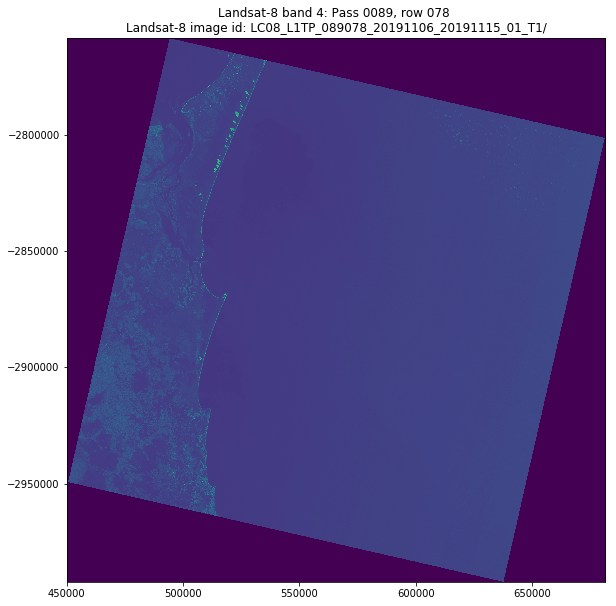

In [11]:
fig, ax = plt.subplots(1, figsize=(12, 10))
show(src_image, ax=ax)
ax.set_title(
    'Landsat-8 band 4: Pass 0089, row 078 \nLandsat-8 image id: '
    + fpath_imid
)
plt.show()

We can convert the black pixels (no data) into white pixels, by using ```numpy``` to set the to NAN

In [12]:
# convert image to numpy

src_image_array = src_image.read(1)
src_image_array = src_image_array.astype('f4')

# replace zero items (ie array pixels out of image frame) with nan

src_image_array[src_image_array == 0] = np.nan

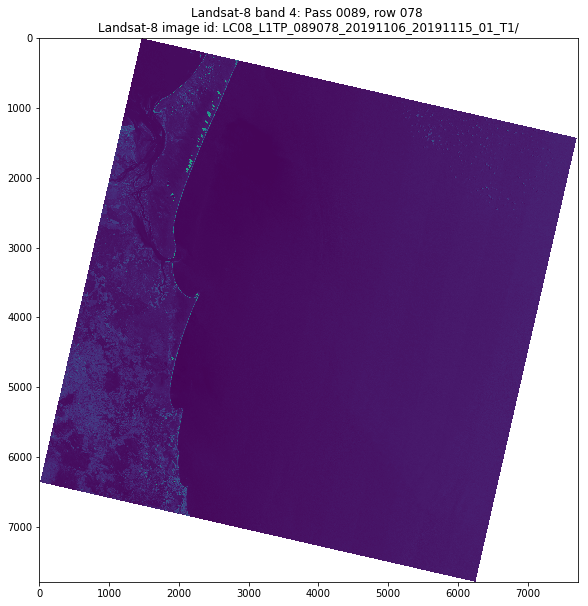

In [13]:
fig, ax = plt.subplots(1, figsize=(12, 10))
show(src_image_array, ax=ax)
ax.set_title(
    'Landsat-8 band 4: Pass 0089, row 078 \nLandsat-8 image id: '
    + fpath_imid
)
plt.show()

In [14]:
# clean up big data objects

src_image_array = 0
src_image = 0

### Getting a Color Image

Now we know how to get a band, we build the URLs for the visible bands.

In [15]:
# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    '''
    normalize: normalize a numpy array so all value are between 0 and 1
    '''
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)


# end normalize

In [16]:
def make_color_image(b1: int, b2: int, b3: int, fpath: str):
    '''
    make_false_color_image: combine nominated Landsat-8 bands into false color image
    
    Parameters:
    b1, b2, b3 int - values between 1 - 6 (inclusive), being a Landsat-8 band number
    
    fpath str - template for URL to Landsat-8 data
    
    Band Number Description       Wavelength Resolution
    Band 1      Coastal / Aerosol 0.433 to 0.453 µm 30 meter
    Band 2      Visible blue      0.450 to 0.515 µm 30 meter
    Band 3      Visible green     0.525 to 0.600 µm 30 meter
    Band 4      Visible red       0.630 to 0.680 µm 30 meter
    Band 5      Near-infrared     0.845 to 0.885 µm 0 meter
    Band 6      Short wavelength infrared 1.56 to 1.66 µm 30 meter
    
    Environment:
    assumes rasterio imported as rio
    assumes boto package  available for AWS file storage access
    '''

    if not (
        b1 > 0
        and b2 > 0
        and b3 > 0
        and b1 < 7
        and b2 < 7
        and b3 < 7
    ):
        raise ValueError(
            f'One or more invalid Landsat-8 band number {b1}, {b2}, {b3} supplied'
        )
    # endif

    # create URLs for each band
    b1_path = fpath[:-6] + f'{b1}.tiff'
    b2_path = fpath[:-6] + f'{b2}.tiff'
    b3_path = fpath[:-6] + f'{b3}.tiff'

    # open URL with rasterio
    b1 = rio.open(b1_path)
    b2 = rio.open(b2_path)
    b3 = rio.open(b3_path)

    # read into numpy array
    b1_np = b1.read(1)
    b2_np = b2.read(1)
    b3_np = b3.read(1)

    # normalize data to 0<->1
    b1_norm = normalize(b1_np)
    b2_norm = normalize(b2_np)
    b3_norm = normalize(b3_np)

    # create three color image
    rgb = np.dstack((b1_norm, b2_norm, b3_norm))

    return rgb


# end make_color_image

In [17]:
# read true color image
rbg = make_color_image(4, 3, 2, fpath)

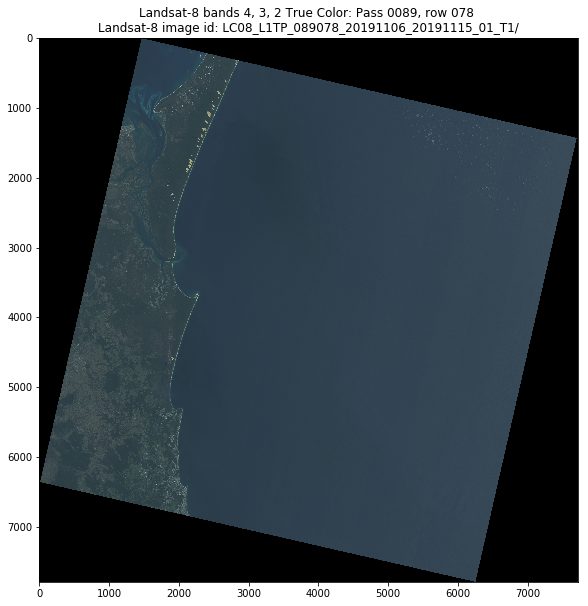

In [18]:
fig, ax = plt.subplots(1, figsize=(12, 10))
ax.set_title(
    'Landsat-8 bands 4, 3, 2 True Color: Pass 0089, row 078 \nLandsat-8 image id: '
    + fpath_imid
)
# show plot
plt.imshow(rbg)

Zoom into to Fraser Island

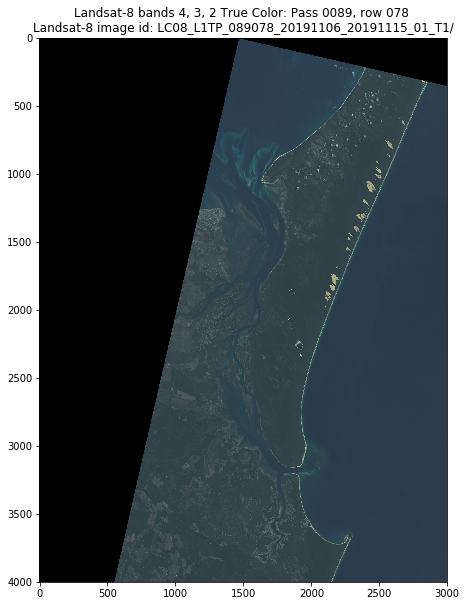

In [19]:
fig, ax = plt.subplots(1, figsize=(12, 10))
ax.set_title(
    'Landsat-8 bands 4, 3, 2 True Color: Pass 0089, row 078 \nLandsat-8 image id: '
    + fpath_imid
)
plt.imshow(rbg[0:4000, 0:3000, :])

In [20]:
# clean up big array
rbg = 0

----
### Agriculture Highlight

To quote:

> "This band combination uses SWIR-1 (6), near-infrared (5) and blue (2). It’s commonly used for crop monitoring because of the use of 
> short-wave and near infrared. Healthy vegetation appears dark green. But bare earth has a magenta hue."

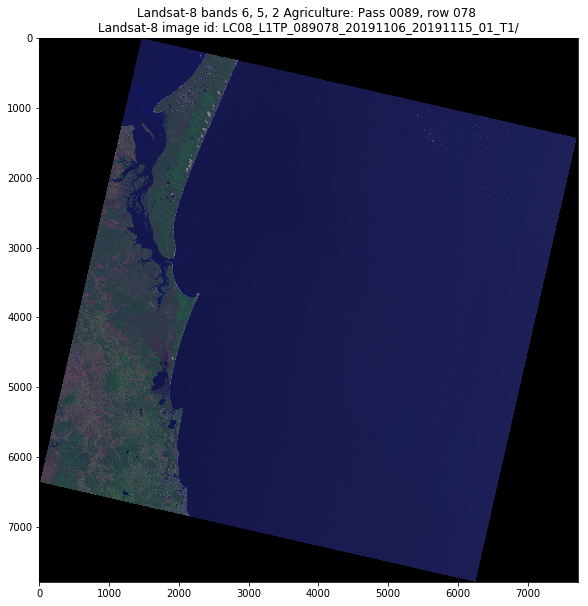

In [21]:
rgb = make_color_image(6, 5, 2, fpath)

fig, ax = plt.subplots(1, figsize=(12, 10))
ax.set_title(
    'Landsat-8 bands 6, 5, 2 Agriculture: Pass 0089, row 078 \nLandsat-8 image id: '
    + fpath_imid
)

plt.imshow(rgb)

In [22]:
# clean up arrays
rgb = 0

----
### Bathymetric

To quote:

> The bathymetric band combination (4,3,1) uses the red (4), green (3) and coastal band to peak into water. The coastal band is useful in coastal, bathymetric and aerosol studies because it reflects blues and violets.

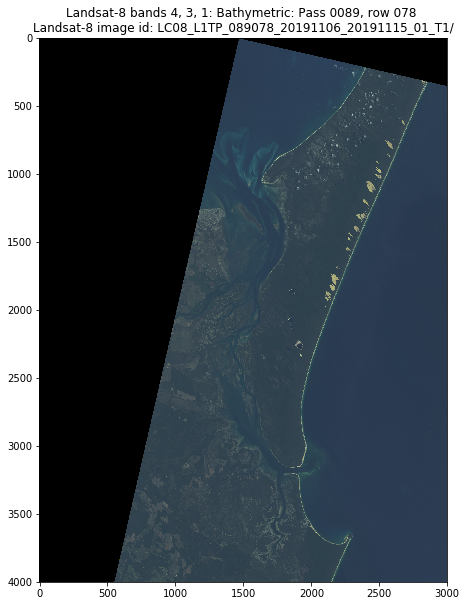

In [23]:
rgb = make_color_image(4, 3, 1, fpath)

fig, ax = plt.subplots(1, figsize=(12, 10))
ax.set_title(
    'Landsat-8 bands 4, 3, 1: Bathymetric: Pass 0089, row 078 \nLandsat-8 image id: '
    + fpath_imid
)

plt.imshow(rgb[0:4000, 0:3000, :])

Indeed, the shallow sea details are enhanced

In [24]:
# clean up array
rgb = 0

-----
### Color Infrared

To quote:

>This band combination is also called the near infrared (NIR) composite. It uses near-infrared (5), red (4) and green (3). Because chlorophyll reflects near infrared light, this band composition is useful for analyzing vegetation. In particular, areas in red have better vegetation health. Dark areas are water and urban areas are white.

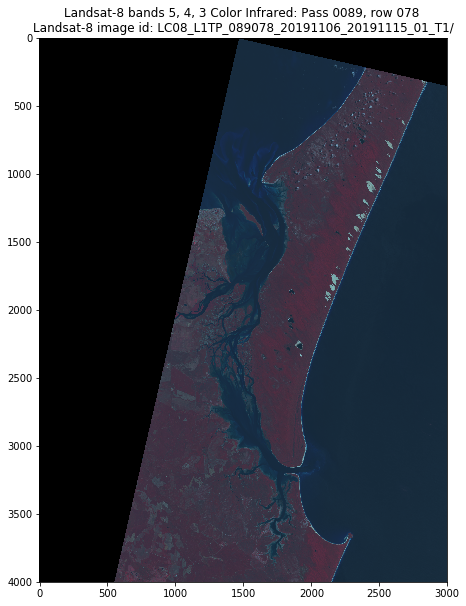

In [25]:
rgb = make_color_image(5, 4, 3, fpath)

fig, ax = plt.subplots(1, figsize=(12, 10))
ax.set_title(
    'Landsat-8 bands 5, 4, 3 Color Infrared: Pass 0089, row 078 \nLandsat-8 image id: '
    + fpath_imid
)

plt.imshow(rgb[0:4000, 0:3000, :])

------
## Equalized Color Images

In the images below, we adjust the brightness of each color plane, so they look less "washed out".

In [30]:
def make_color_image_eqh(
    b1: int, b2: int, b3: int, fpath: str
):
    '''
    make_false_color_image: combine nominated Landsat-8 bands into false color image
    
    Parameters:
    b1, b2, b3 int - values between 1 - 6 (inclusive), being a Landsat-8 band number
    
    fpath str - template for URL to Landsat-8 data
    
    Band Number Description       Wavelength Resolution
    Band 1      Coastal / Aerosol 0.433 to 0.453 µm 30 meter
    Band 2      Visible blue      0.450 to 0.515 µm 30 meter
    Band 3      Visible green     0.525 to 0.600 µm 30 meter
    Band 4      Visible red       0.630 to 0.680 µm 30 meter
    Band 5      Near-infrared     0.845 to 0.885 µm 0 meter
    Band 6      Short wavelength infrared 1.56 to 1.66 µm 30 meter
    
    Environment:
    assumes rasterio imported as rio
    assumes boto package  available for AWS file storage access
    '''

    if not (
        b1 > 0
        and b2 > 0
        and b3 > 0
        and b1 < 7
        and b2 < 7
        and b3 < 7
    ):
        raise ValueError(
            f'One or more invalid Landsat-8 band number {b1}, {b2}, {b3} supplied'
        )
    # endif

    # create URLs for each band
    b1_path = fpath[:-6] + f'{b1}.tiff'
    b2_path = fpath[:-6] + f'{b2}.tiff'
    b3_path = fpath[:-6] + f'{b3}.tiff'

    # open URL with rasterio
    b1 = rio.open(b1_path)
    b2 = rio.open(b2_path)
    b3 = rio.open(b3_path)

    # read into numpy array
    b1_np = b1.read(1)
    b2_np = b2.read(1)
    b3_np = b3.read(1)

    eq_b1 = skimage.exposure.equalize_hist(b1_np)
    eq_b2 = skimage.exposure.equalize_hist(b2_np)
    eq_b3 = skimage.exposure.equalize_hist(b2_np)

    # normalize data to 0<->1
    b1_norm = normalize(eq_b1)
    b2_norm = normalize(eq_b2)
    b3_norm = normalize(eq_b3)

    # create three color image
    rgb = np.dstack((b1_norm, b2_norm, b3_norm))

    return rgb


# end make_color_image_eqh

####  True Color Image Equalized 

Make equalized color image (histogram of color values spread out in all three color planes).

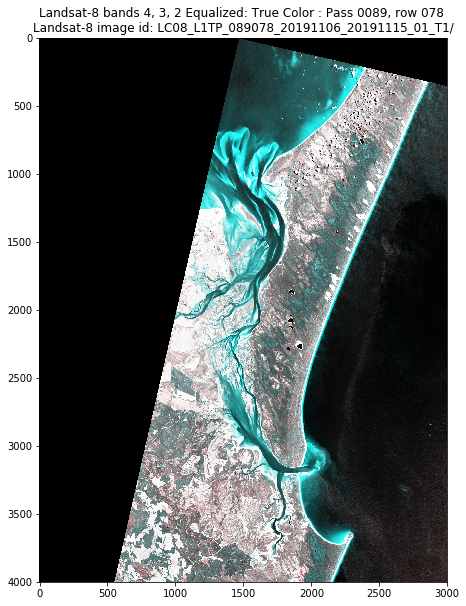

In [31]:
rgb = make_color_image_eqh(4, 3, 2, fpath)

fig, ax = plt.subplots(1, figsize=(12, 10))
ax.set_title(
    'Landsat-8 bands 4, 3, 2 Equalized: True Color : Pass 0089, row 078 \nLandsat-8 image id: '
    + fpath_imid
)

plt.imshow(rgb[0:4000, 0:3000, :])

In [32]:
# clean up arrays
rgb = 0

#### Bathymetric Highlight 

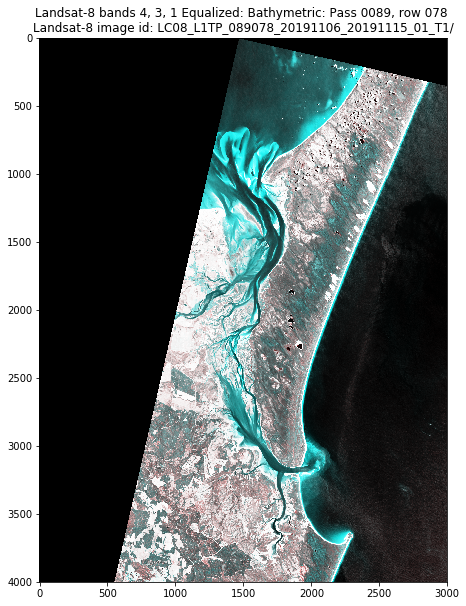

In [33]:
rgb = make_color_image_eqh(4, 3, 1, fpath)

fig, ax = plt.subplots(1, figsize=(12, 10))
ax.set_title(
    'Landsat-8 bands 4, 3, 1 Equalized: Bathymetric: Pass 0089, row 078 \nLandsat-8 image id: '
    + fpath_imid
)

plt.imshow(rgb[0:4000, 0:3000, :])

I can't really tell the difference between these two images

## Conclusions / Summary

Once conclusion I drew from these little experiments is that color plane equalization works fine to enhance a true color image, but might not be the correct way to approach false color images.

-------------------
## Reproducibility

### Notebook version status

In [34]:
theNotebook = '2020-01-15-dc-Landsat8BandsProject.ipynb'

In [35]:
# show info to support reproducibility


def python_env_name():
    envs = subprocess.check_output(
        'conda env list'
    ).splitlines()
    # get unicode version of binary subprocess output
    envu = [x.decode('ascii') for x in envs]
    active_env = list(
        filter(lambda s: '*' in str(s), envu)
    )[0]
    env_name = str(active_env).split()[0]
    return env_name


# end python_env_name

print('python version : ' + sys.version)
print('python environment :', python_env_name())

print('current wkg dir: ' + os.getcwd())
print('Notebook name: ' + theNotebook)
print(
    'Notebook run at: '
    + str(datetime.datetime.now())
    + ' local time'
)
print(
    'Notebook run at: '
    + str(datetime.datetime.utcnow())
    + ' UTC'
)
print('Notebook run on: ' + platform.platform())

python version : 3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
python environment : ac5-py37
current wkg dir: C:\Users\donrc\Documents\JupyterNotebooks\Landsat8BandsNotebookProject\develop
Notebook name: 2020-01-15-dc-Landsat8BandsProject.ipynb
Notebook run at: 2020-01-16 21:28:46.211241 local time
Notebook run at: 2020-01-16 11:28:46.211241 UTC
Notebook run on: Windows-10-10.0.18362-SP0


In [36]:
%watermark

2020-01-16T21:28:46+10:00

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit


In [37]:
%watermark -h -iv

boto3      1.11.0
skimage    0.14.1
platform   1.0.8
rasterio   1.0.21
matplotlib 3.0.2
numpy      1.15.4
host name: DESKTOP-SODFUN6
